# Models and Measurements of Electricity Use In Lake Sentani

# Abstract:

 A simulation model of secondary energy consumption in (grid) connected locations will be created to estimate the optimum load capacity needed to facilitate the perceived energy requirement for non-electrified locations.
 (short term model analyzes households while long term should include all demand points)
 
 The model is created from survey data collected in Lake Sentani, Indonesia and contains information regarding multiple aspects of daily life from energy demand points, consisting of households, schools, and other electrified establishments.
 
  Information about appliance ownership will be used to estimate the total amount of appliances present in each grid connected village. Appliance use times will then be analyzed in conjuction with infered appliance power ratings to determine the amount of energy(kWh) consumed.

 [From that information we can then say either:
 
 a) a village that consists of (x) number of households will need a (y) kWh producing microgrid.
 
 b) by determining an average energy use from each appliance combined with information of future appliance purchases: a village that consists of (x) number of appliances will need a (y) kWh producing microgrid. 
 (app_buy/ vs app_buy_imm/ controversy) 

# Introduction

 (Importance of accuracy for microgrid installation). 

 It is assumed that the PLN grid is fully functional and allows demand-points to meet daily electricity requirements for the desired (quality of living). 
 
 The sample survey data is projected to reflect the population of Lake Sentani, in which the (actual) quantity of demand points were gathered from local resources. 
 
 In certain villages, 100% survey participation was achieved; however, in  most of those cases there was less than a 100% rate of response for each question, meaning certain households/demand points withheld a response for varying (and currently undetermined) reasons. 
 
 Non-responses will be calculated in a way that reflects the rest of the village demographic. In other villages with less than 100% survey participitation , the proportion of responding households comapared to total demand-points will be used to reflect the entire village.Example:

| Village | `%`Survey | Appliance | survey count |  projected   |
|---------|-----------|-----------|--------------|--------------|
| Abar    |    50     |    TV     |    10        |    20        |
| Ajau    |    100    |    TV     |    5         |     5        |

## Computation and Visualization Tools:
 Multiple libraries are used to facilitate data computation and graphical plotting.
 * Visualization
     * Seaborn: creating graphs.
     * matplotlib.pyplot: plotting graphs
 * Computation
     * Pandas: Panel data (s?): `groupby()` 
     * Numpy: Numerical python: `count()`,`mean()`,etc

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Survey Information
 
 Data is kept in an excel spreadsheet that is downloaded from the Ona platform and then cleaned to correct entries(cleaning definition for short term model).
 
 The pysentani library contains information based on gathered local knowledge. The Access type function is used to differentiate between the four levels of connectivity, PLN grid, two types of microgrids, and non-electrified locations.
 * Perusahaan Listrik Negara(PLN) is the local government utility, translated from Malay as State Electric Company.

In [2]:
import pysentani as sti
survey = pd.read_excel('../data-anonymous/sentani-merged-cleaned-anonymous-2014-11-29.xlsx')
survey['access_type'] = sti.access_type(survey)

In [3]:
#this cell used to describe types of demand points on the grid and will not remain in this form on final draft 
#grid = (survey['access_type']=="PLN_grid")
#survey['demand_point'][grid].value_counts()

In [4]:
print("Connectivity Level:")
print(survey['access_type'].unique())

Connectivity Level:
['no_access' 'community_microgrid' 'PLN_grid' 'PLN_microgrid']


# Methods

## Appliance Ownership

The number of appliances for each village is needed to calculate an energy usage estimate. We start with a dataframe of current ownership information for appliances in each surveyed household with an access type identifier. Ownership is indicated as 1, non-ownership as 0, and non-responses as Nan.(reword) Survey is set to identify household responses only(short term).

In [5]:
survey = survey[survey['demand_point'] == 'household']

In [6]:
appliances = ['lighting','TV','fridge','rice_cooker','radio','fan']

In [7]:
now_columns = ['app_now/{}'.format(a) for a in appliances]
now_columns.append('access_type')
survey[now_columns].head()

,app_now/lighting,app_now/TV,app_now/fridge,app_now/rice_cooker,app_now/radio,app_now/fan,access_type
0,0,1,0,0,1,0,no_access
1,1,1,0,0,1,0,no_access
2,0,1,0,0,0,0,no_access
3,1,1,0,0,0,0,no_access
4,1,0,0,0,0,0,no_access


The field is now narrowed to only households with PLN grid connections.

In [8]:
grid = (survey['access_type']=="PLN_grid")
grid_appliance = survey[now_columns][grid]
grid_appliance.head()

,app_now/lighting,app_now/TV,app_now/fridge,app_now/rice_cooker,app_now/radio,app_now/fan,access_type
46,1,1,0,1,0,0,PLN_grid
47,1,1,1,1,0,0,PLN_grid
48,1,1,1,1,0,0,PLN_grid
49,1,1,1,1,0,0,PLN_grid
50,1,1,0,1,0,0,PLN_grid


The sum of each column represents the number of appliances.

In [9]:
grid_appliance_count = grid_appliance.sum()
grid_appliance_count#Fix access type count display

app_now/lighting                                                     487
app_now/TV                                                           428
app_now/fridge                                                       161
app_now/rice_cooker                                                  146
app_now/radio                                                        167
app_now/fan                                                           76
access_type            PLN_gridPLN_gridPLN_gridPLN_gridPLN_gridPLN_gr...
dtype: object

The mean of a binary data field represents a proportion and is calculated from the sum of appliance columns divided by the number of responses. Calculation does not include null responses.

In [10]:
grid_appliance_mean = grid_appliance.mean()
grid_appliance_mean

app_now/lighting       0.927619
app_now/TV             0.815238
app_now/fridge         0.306667
app_now/rice_cooker    0.278095
app_now/radio          0.318095
app_now/fan            0.144762
dtype: float64

In [11]:
test = grid_appliance.dropna()
test.mean()

app_now/lighting       0.927619
app_now/TV             0.815238
app_now/fridge         0.306667
app_now/rice_cooker    0.278095
app_now/radio          0.318095
app_now/fan            0.144762
dtype: float64

The number of null responses are needed and should be included in the estimtation in order to accurately reflect the population.

`isnull()` identifies NaN responses as True and all others as False. `astype('float')` assigns binary values to True(1)/False(0). The `sum()` is equal to the number of non-responses.

In [12]:
null_grid_appliance = grid_appliance.isnull().astype('float').sum()
null_grid_appliance

app_now/lighting       23
app_now/TV             23
app_now/fridge         23
app_now/rice_cooker    23
app_now/radio          23
app_now/fan            23
access_type             0
dtype: float64

Each appliance category has 23 non responses which is indicative that 23 households did not respond to appliance ownership at all. The product of this column and the appliance ownership mean will determine how many appliances those households should have if they are similar to other grid households. 
 * I know that these are distributed uniformly but I don't think this calculation shows that precisely#

In [13]:
grid_appliance_correction = null_grid_appliance * grid_appliance_mean
grid_appliance_correction 
#access type again. # why are the appliances reordered now?

access_type                  NaN
app_now/TV             18.750476
app_now/fan             3.329524
app_now/fridge          7.053333
app_now/lighting       21.335238
app_now/radio           7.316190
app_now/rice_cooker     6.396190
dtype: float64

The sum of the correction with the original appliance count produces a more accurate ownership representation.

In [14]:
grid_appliance_actual = grid_appliance_count + grid_appliance_correction
grid_appliance_actual

access_type                 NaN
app_now/TV             446.7505
app_now/fan            79.32952
app_now/fridge         168.0533
app_now/lighting       508.3352
app_now/radio          174.3162
app_now/rice_cooker    152.3962
dtype: object

# Checkpoint

 This is no longer a binary data frame and poses challenges to the current method. I need to explore other options. Below this point should be considered unprepared for review.

`groupby` with `mean()` is used to filter mean appliance ownership by village. `groupby` includes only non-null responses in the calculation.

In [15]:
#grid_appliance_village_mean = grid_appliance_actual.groupby(survey['village_name']).mean()
#grid_appliance_village_mean

In [16]:
#grid_appliance_mean['village_name'] = grid_appliance_mean.index
#melted = pd.melt(grid_appliance_mean, 
#                 id_vars=['village_name'],
#                 value_vars=['app_now/lighting','app_now/TV','app_now/fridge',
#                             'app_now/rice_cooker','app_now/radio','app_now/fan'],
#                 value_name='Percent Ownership')

In [17]:
#plt.figure(figsize=(18,8))
#sns.barplot(x='village_name', y='Percent Ownership', hue='variable', data=melted)

# Appliance Use Times

In [18]:
for a in appliances:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(a)
    survey[wk_col] = survey[wk_col][survey[wk_col]<=7]
    hr_col = 'app_{}_hrs'.format(a)
    survey[hr_col] = survey[hr_col][survey[hr_col]<=24]
    weekly_hr_col = 'weekly_hrs/{}'.format(a)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]
    #returns weekly hours less than or equal to 168
    #survey[weekly_hr_col] = survey[weekly_hr_col][survey[weekly_hr_col]<=168]
    #energy_col = 'daily_{}_energy'.format(a)

wk_columns = [f for f in survey.columns if 'weekly' in f]

In [19]:
#[survey[wk_columns][grid]]

In [20]:
weekly_hours = survey[wk_columns]
grid_weekly_hours = weekly_hours[grid]
grid_weekly_hours.head()

,weekly_hrs/lighting,weekly_hrs/TV,weekly_hrs/fridge,weekly_hrs/rice_cooker,weekly_hrs/radio,weekly_hrs/fan
46,63,28,NaN,24,NaN,NaN
47,77,49,168,8,NaN,NaN
48,84,42,168,28,NaN,NaN
49,84,70,168,7,NaN,NaN
50,42,84,NaN,8,NaN,NaN


In [21]:
#wk_columns = [f for f in survey.columns if 'weekly' in f]
id_columns = ['village_name']

columns = wk_columns + id_columns
survey[columns] = survey[columns][grid]
plt_data = pd.melt(survey[columns], value_vars=wk_columns, id_vars=id_columns)

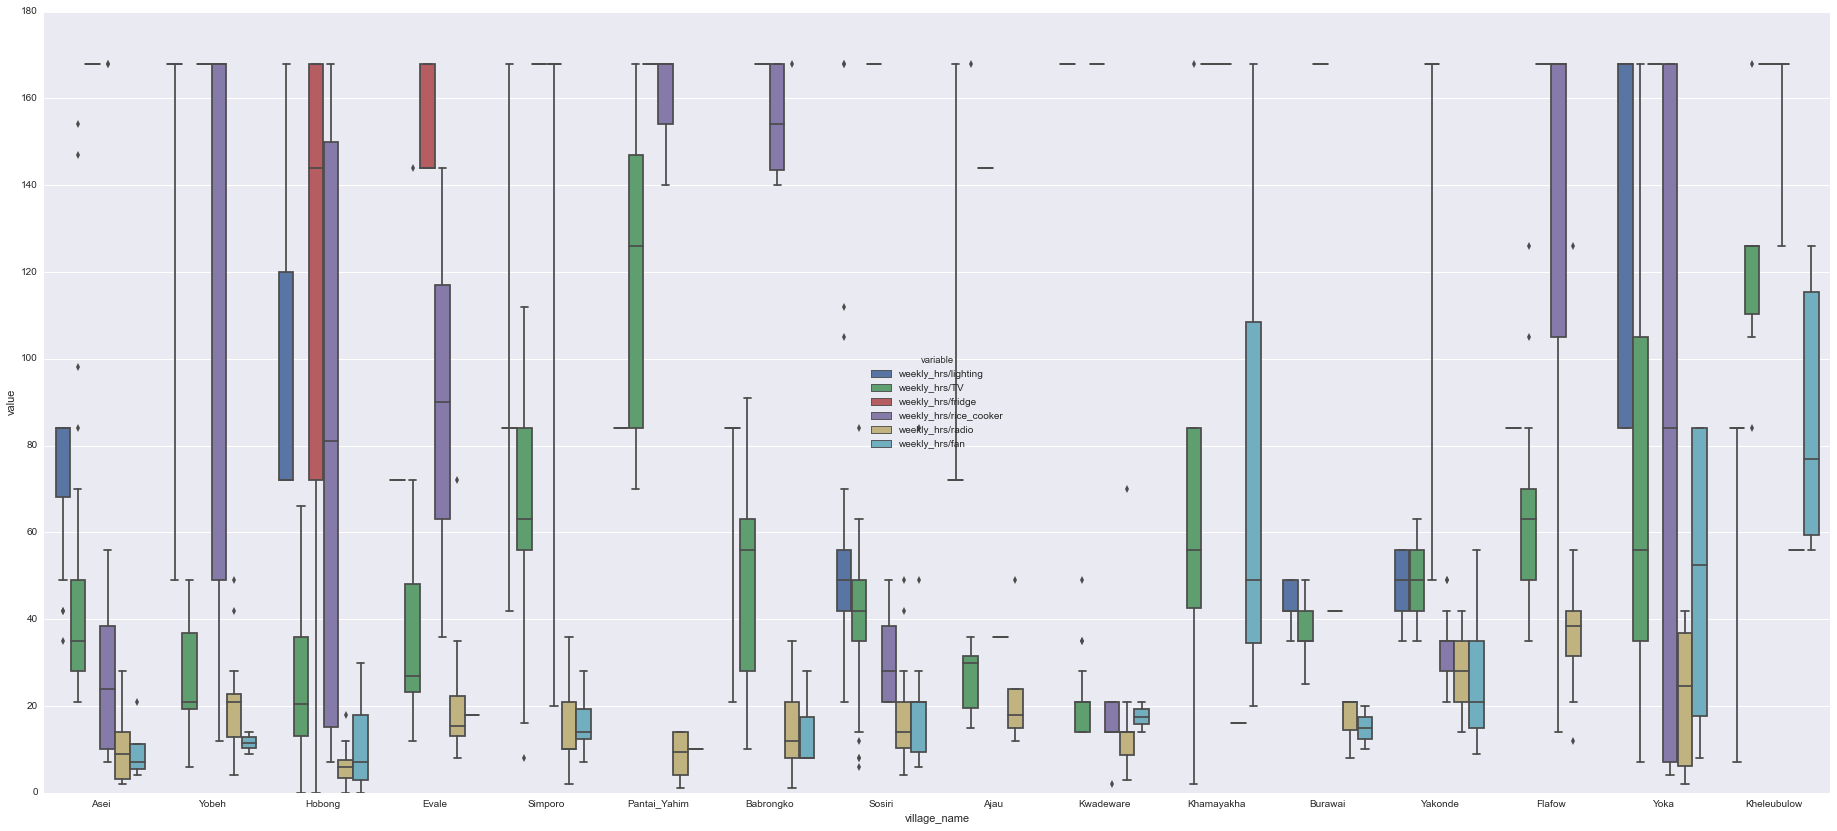

In [22]:
plt.figure(figsize=(32,14))
sns.boxplot(data=plt_data, hue='variable', y='value', x='village_name')

In [23]:
grid_weekly_hours_count = grid_weekly_hours.count()
grid_weekly_hours_count

weekly_hrs/lighting       481
weekly_hrs/TV             421
weekly_hrs/fridge         153
weekly_hrs/rice_cooker    143
weekly_hrs/radio          164
weekly_hrs/fan             75
dtype: int64

In [24]:
null_hours = grid_weekly_hours.isnull().astype('float')
null_hours.sum()

weekly_hrs/lighting        67
weekly_hrs/TV             127
weekly_hrs/fridge         395
weekly_hrs/rice_cooker    405
weekly_hrs/radio          384
weekly_hrs/fan            473
dtype: float64

In [25]:
grid_appliance.columns = [col.replace('app_now/', '') for col in grid_appliance.columns]
grid_weekly_hours.columns = [col.replace('weekly_hrs/', '') for col in grid_weekly_hours.columns]
hours_response_proportion = grid_weekly_hours.count() / grid_appliance.count()
hours_response_proportion

TV             0.801905
access_type         NaN
fan            0.142857
fridge         0.291429
lighting       0.916190
radio          0.312381
rice_cooker    0.272381
dtype: float64

In [26]:
grid_appliance.mean()

lighting       0.927619
TV             0.815238
fridge         0.306667
rice_cooker    0.278095
radio          0.318095
fan            0.144762
dtype: float64

In [27]:
ownership_data = hours_response_proportion * grid_appliance.count()
ownership_data

TV             421
access_type    NaN
fan             75
fridge         153
lighting       481
radio          164
rice_cooker    143
dtype: float64

In [28]:
grid_weekly_hours_mean = grid_weekly_hours.mean()
grid_weekly_hours_mean

lighting        85.467775
TV              54.028504
fridge         163.771242
rice_cooker     91.545455
radio           20.225610
fan             27.293333
dtype: float64

# Grid Load

In [29]:
powers = {'TV':0.075, 'fridge':0.200, 'radio':0.100, 'fan':0.135, 'rice_cooker':0.700, 'lighting':0.400}
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]
    
wk_columns = [f for f in survey.columns if 'weekly' in f]
en_columns = [f for f in survey.columns if 'daily' in f]
id_columns = ['village_name', 'demand_point', 'access_type']

columns = wk_columns + id_columns
plt_data = pd.melt(survey[columns], value_vars=wk_columns, id_vars=id_columns)

In [30]:
test = survey[en_columns].groupby(survey['village_name']).sum()
test

,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy
village_name,,,,,,
Ajau,3.717857,12.342857,1.685714,NaN,3.6,58.971429
Asei,11.571429,43.200000,0.928571,0.752143,71.2,102.000000
Babrongko,25.028571,57.600000,6.971429,1.832143,171.5,266.800000
Burawai,1.992857,19.200000,0.714286,0.578571,4.2,12.400000
Evale,6.878571,21.942857,2.685714,0.347143,18.0,61.714286
Flafow,40.200000,28.800000,7.271429,NaN,77.0,326.400000
Hobong,4.232143,22.628571,1.028571,1.118571,33.7,83.657143
Khamayakha,3.021429,4.800000,0.228571,4.570714,16.8,NaN
Kheleubulow,28.575000,67.200000,0.800000,9.990000,281.4,106.000000
